# AIM: Creating a mosaic from L2 swath files, performing a regrid first

This notebook adapts the example codes here: 
- 1. http://hdfeos.org/zoo/MORE/LAADS/MOD/MOD04_L2_regrid.py
- 2. http://hdfeos.org/zoo/MORE/LAADS/MOD/MOD04_L2_merge.z.py


The overall **aim** is to create a daily, gridded ("_L3_") field from all individual swath files for that day _that cover a certain area of interest_ (i.e. not a global field)
- The individual swath files were downloaded from https://ladsweb.modaps.eosdis.nasa.gov/search/order
    - the search area functionality was used to select only swaths covering my area of interest (Canada)
- The code here operates on the SDS '`Viewing_Zenith_10km`' from MYDATML2 files
    - ultimately I want to analyse AOD data, but I am using this SDS to most easily visualise the results of regridding and mosaicing methods. As this method demonstrates, the viewing zenith angle looks to be necessary anyway to create a mosaic correctly.
    

**IF YOU JUST WANT TO SEE THE CODE, SKIP TO THE MAIN BLOCK OF CODE FOR CREATING THE MOSAIC BELOW!**
- damn, I currently cannot get internal hyperlinks working, it would be nice to fix this one day!


## Method

The following approach is applied to a list of L2 swath files for a given day:

1. Read data field of interest from file (herein referred to as the '_swath_'), prepare it for analysis by scaling and masking it according to in-file attributes  
<br>

2. Regrid the swath using the _nearest neighbour_ method from `pyresample` (adapting the example 1 above from hdfeos.org). Regridding is necessary because it is easier to analyse data over a long time period if they are on a common grid, particularly if the analysis is focused on spatial and temporal patterns
<br>

3. Combine the regridded swath with the mosaic (L3) for the given day by applying the following rules:
    - (if no mosaic exists, this is the first swath of the day so the mosaic needs to be initialised using the regridded swath) 
    1. if a grid box has no value in the mosaic but a value in the swath, simply copy the value from the swath on to the mosaic
    2. if a grid box has a value in the mosaic AND a value in the swath:
        - if the viewing zenith angle is less in the swath than the mosaic, then overwrite the value in the mosaic with the value in the swath as this means the grid box in the swath is closer to the instrument's nadir  
        - if the viewing zenith angle is less in the mosaic than in the swath, do nothing; the grid box in the mosaic is closer to the instrument's nadir than in the swath (i.e. an orbit earlier in the day passed more directly over the grid box than the orbit from which this swath was obtained)
    3. if a grid box has no value in the swath but a value in the mosaic, do nothing


**NOTE 1:** This method has been developed because the mosaic/merge method outlined in example 2 above from hdfeos.org does not take into account the fact that swaths can overlap spatially, resulting in values from earlier swaths in the day being overwritten by values from swaths that occur later in the day (this problem is demonstrated in the notebook `L2_mosaic_testing.ipynb`)

### Import packages required

In [1]:
import os #general utility
import glob #general utility                                                                 
import numpy as np #general utility
import copy #general utility
from pyhdf.SD import SD, SDC #for reading the L2 hdf files
from pyresample import kd_tree,geometry #regridding
from pyresample.geometry import GridDefinition, SwathDefinition #regridding
from pyresample.kd_tree import resample_nearest #regridding
import matplotlib.pyplot as plt #plotting tools
import cartopy.crs as ccrs #plotting tools
import cartopy.feature as cf #plotting tools
import xarray as xr #for saving results to netcdf for later analysis

### Create a function for reading a SDS (and corresponding latlons) from a swath file
- It is easiest to place this in a function as SDS requires screening for fillvalues and correcting according to in-file attributes before it is ready for analysis
    - (Therefore do not want to repeatedly do this in main processing loop)
- (_SDS = 'Scientific Data Set'_)

In [2]:
def read_hdf(file, DATAFIELD_NAME):
    
    '''
    -read a specified datafield ('SDS') from a MODIS L2 hdf file
    -screen missing values and correct real values according to in-file offset and scale-factor attributes
    -read corresponding latlons
    -return the analysis-ready datafield (as a masked array) and latlons to parent process
    
    '''
    
    #open file and get data field
    reader=open(file)
    hdf=SD(file,SDC.READ)
    data2d=hdf.select(DATAFIELD_NAME)
    data=data2d[:,:].astype(np.double)

    
    #get latlons and variable attributes
    lat=hdf.select('Latitude_10km')
    latitude=lat[:,:]
    lon=hdf.select('Longitude_10km')
    longitude=lon[:,:]

    attrs=data2d.attributes(full=1)
    add_offset=attrs['add_offset'][0]
    _FillValue=attrs['_FillValue'][0]
    scale_factor=attrs['scale_factor'][0]
    units=attrs['units'][0]

    
    #prepare datafield for processing
    data[data==_FillValue]=np.nan
    data=(data-add_offset)*scale_factor 
    datam=np.ma.masked_array(data,np.isnan(data))

    
    #return datafield prepared for analysis, and latlons
    return datam,latitude,longitude


    #done

### Define the target grid to regrid swath data to before creating the mosaic
- Only needs to be done once, so best to do it outside of main processing loop
- Target projection = standard latlon grid, 0.1 x 0.1 degree resolution

**NOTE:** \
This is almost a direct copy of example from hdfeos.org (example 1 above), but I have expanded the radius of influence (`ri`) to 50000 meters instead of 10000 as in that example. \
This is to remove artefacts at the edge of the swath when resampled with an ri of 10000, which I think is due to the spatial resolution of the raw swath increasing towards the swath edge. Expanding the ri allows for these 'edge' grid boxes in the target grid to be filled with values from pixels that are further away.
- Testing the `ri` parameter is outlined in more detail in the notebook `nearest_neighbour_ri_testing.ipynb`

In [3]:
#specify target grid features
#(NOTE: global grid is unnecessary but is simple for now!)
min_lon = -180
max_lon = 180 
min_lat = -90
max_lat = 90
cellSize = 0.1 #0.1 x 0.1 degree resolution

x0, xinc, y0, yinc = (min_lon, cellSize, max_lat, -cellSize)


#derive number of grid boxes in x and y direction
nx = int(np.floor((max_lon - min_lon) / cellSize))
ny = int(np.floor((max_lat - min_lat) / cellSize))


#derive x and y coordinates
x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
lon_g,lat_g = np.meshgrid(x, y)


#create target grid object using pyresample 
grid_def = GridDefinition(lons = lon_g, lats = lat_g)


#Set radius_of_influence in meters for the reprojection.
ri = 50000 #increased from 10000 in hdfeos.org regrid example 

### Specify location of files to process (datadir) and name of datafield to read from files

- (some utility code is included here (commented out) for inspecting contents of file)

In [4]:
datadir='/path/to/files/' #'/Users/ianashpole/Computing/DUST/data/modis/L2/501885579/'
DATAFIELD_NAME='Viewing_Zenith_10km'

# block below for inspecting SDSs contained in files
# FILE_NAME=datadir+'MYDATML2.A2022214.1830.061.2022215180306.hdf'
# hdf = SD(FILE_NAME, SDC.READ)
# print(hdf.datasets())

# block below for inspecting attributes attached to this datafield ('SDS')
# data2d=hdf.select(DATAFIELD_NAME)
# data=data2d[:,:].astype(np.double)
# attrs=data2d.attributes(full=1)
# print(attrs)

### This is the main block of code for creating the mosaic
The code block consists of the following steps:

1. List and loop over the swath files to be processed 
2. Read 'analysis-ready' datafield ('SDS') from swath file 
    - (Use `read_hdf`function defined above)
3. Regrid the datafield
    - (Use `grid_def` and `ri` specified initialised above)
4. Build the mosaic according to the rules outlined under **Method** in the notebook intro

In [5]:
#1. list files and loop
flist = sorted(glob.glob(datadir+'MYDATML2.A2022214.*.hdf'))
for f in range(0, len(flist)): #for 1 (f)
    
    file=flist[f]
    filename = flist[f].split('/')[-1]
    print('processing:', f, filename)
    
    
    #2. read analysis-ready SDS ('datam') and latlons from file using read_hdf function created above.
    #this is the 'swath'
    datam, latitude, longitude = read_hdf(file, DATAFIELD_NAME)
    
    
    #3. regrid the swath ('swath_r') using grid initialised above
    swathDef = SwathDefinition(lons = longitude, lats = latitude)   
    swath_r = resample_nearest(swathDef, datam, grid_def, radius_of_influence = ri, 
                               epsilon = 0.5, fill_value = np.nan)

    
    #4. build the mosaic according to the conditions outlined in Methods:
    
    #a. if this is the first file, then need to initialise the mosaic
    if f == 0:
        mosaic = swath_r
    
    else: #else 1 (f != 0; mosaic already initialised)

        
        #b. need to update grid boxes in mosaic according to certain conditions: 
        
        #condition 1: grid box values are finite in mosaic AND swath; 
        #only update mosaic if viewing angle is less in swath than mosaic 
        #(i.e. the grid box is closer to nadir for this swath)
        to_replace = np.where((np.isfinite(swath_r)) & (np.isfinite(mosaic)) & 
                              (swath_r < mosaic))
        mosaic[to_replace] = swath_r[to_replace]
        
        
        #condition 2: grid boxes have a finite value in the swath but not in the mosaic
        #(i.e. this grid box has not yet featured in a swath)
        to_replace = np.where((np.isfinite(swath_r)) & (~np.isfinite(mosaic))) 
        mosaic[to_replace] = swath_r[to_replace]       
        

        #end else 1
    
    #end for 1
    
#finished
print('finished processing files')

processing: 0 MYDATML2.A2022214.1200.061.2022215174300.hdf
processing: 1 MYDATML2.A2022214.1205.061.2022215174618.hdf
processing: 2 MYDATML2.A2022214.1335.061.2022215175335.hdf
processing: 3 MYDATML2.A2022214.1340.061.2022215175442.hdf
processing: 4 MYDATML2.A2022214.1345.061.2022215172424.hdf
processing: 5 MYDATML2.A2022214.1505.061.2022215175324.hdf
processing: 6 MYDATML2.A2022214.1510.061.2022215180301.hdf
processing: 7 MYDATML2.A2022214.1515.061.2022215175001.hdf
processing: 8 MYDATML2.A2022214.1520.061.2022215172759.hdf
processing: 9 MYDATML2.A2022214.1640.061.2022215174756.hdf
processing: 10 MYDATML2.A2022214.1645.061.2022215164953.hdf
processing: 11 MYDATML2.A2022214.1650.061.2022215180022.hdf
processing: 12 MYDATML2.A2022214.1655.061.2022215175702.hdf
processing: 13 MYDATML2.A2022214.1820.061.2022215180131.hdf
processing: 14 MYDATML2.A2022214.1825.061.2022215181331.hdf
processing: 15 MYDATML2.A2022214.1830.061.2022215180306.hdf
processing: 16 MYDATML2.A2022214.1835.061.20222151

### Plot the mosaic
- Check that it makes sense!

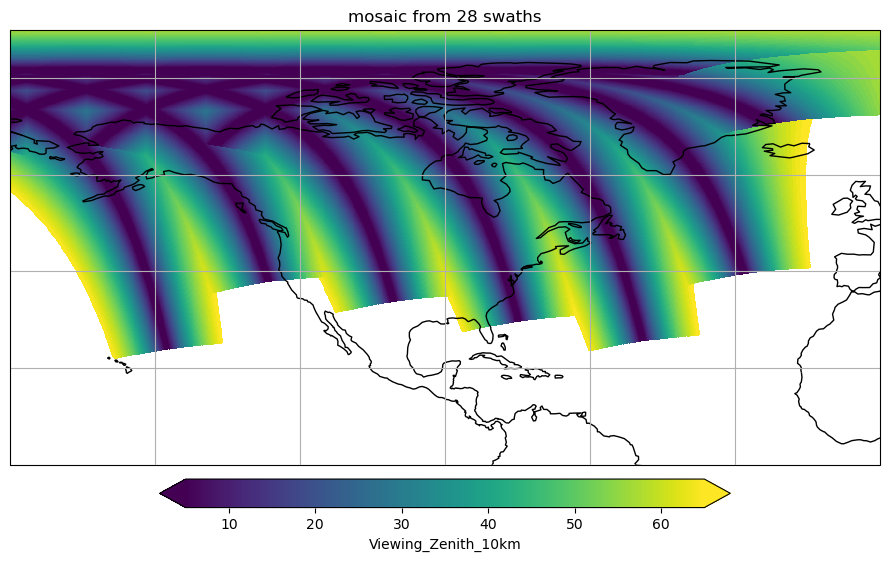

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       subplot_kw = {'projection': ccrs.PlateCarree()},
                       figsize = (9,15))

ax.set_extent([-180,-0,0,90], ccrs.PlateCarree())
img = ax.pcolormesh(lon_g, lat_g, mosaic, transform = ccrs.PlateCarree(),
                    cmap = plt.cm.viridis, vmin = 5, vmax = 65)

ax.coastlines()
ax.gridlines()
ax.set_title('mosaic from '+str(len(flist))+' swaths')

cbar = fig.colorbar(img, ax = ax, orientation = 'horizontal', extend = 'both', 
                    fraction = 0.02, pad = 0.01)
cbar.set_label(DATAFIELD_NAME)

fig.tight_layout()
plt.show()

___This looks good??___

### Save mosaic to netcdf for analysis elsewhere
- Use xarray

In [7]:
#create xarray dataset object
ds = xr.Dataset(
    data_vars=dict(Viewing_Zenith_10km_mosaic=(["x", "y"], mosaic)),
    coords=dict(lon=(["x", "y"], lon_g),lat=(["x", "y"], lat_g)),
    attrs=dict(description="mosaic created by Ian Ashpole using L2_mosaic_with_regrid_final.ipynb"),
)


#save to .nc
ds.to_netcdf('test_mosaic.nc')

## FINISHED
